## Neural Network for Classification

In our previous notebooks, we cleaned the data, built some preliminary ML models, and explored word embeddings. In this notebook, we try our hand building a classification model using neural networks.

### Imports and Mounting Drive

In [3]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [4]:
%load_ext autoreload
%autoreload 2
from functions import *

np.random.seed(17)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the Data

In [5]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
276558,The Phenomenology Of Spirit,Hegel,german_idealism,One difficulty which should be avoided comes f...,One difficulty which should be avoided comes f...,238,one difficulty which should be avoided comes f...,"['one', 'difficulty', 'which', 'should', 'be',...",one difficulty which should be avoid come fro...
172417,Naming And Necessity,Kripke,analytic,He may not think that this picks out anyone un...,He may not think that this picks out anyone un...,53,he may not think that this picks out anyone un...,"['he', 'may', 'not', 'think', 'that', 'this', ...",-PRON- may not think that this pick out anyon...
45021,Aristotle - Complete Works,Aristotle,aristotle,Now if someone were to ask 'Is a thing that wh...,Now if someone were to ask 'Is a thing that wh...,62,now if someone were to ask 'is a thing that wh...,"['now', 'if', 'someone', 'were', 'to', 'ask', ...",now if someone be to ask ' be a thing that wh...
183256,Philosophical Troubles,Kripke,analytic,According to the Karttunen and Peters filterin...,According to the Karttunen and Peters filterin...,102,according to the karttunen and peters filterin...,"['according', 'to', 'the', 'karttunen', 'and',...",accord to the Karttunen and Peters filtering ...
240186,Off The Beaten Track,Heidegger,phenomenology,"As knowing, preservation of the work is the so...","As knowing, preservation of the work is the so...",120,"as knowing, preservation of the work is the so...","['as', 'knowing', 'preservation', 'of', 'the',...","as know , preservation of the work be the sob..."


### Build a Baseline LSTM Model

In [6]:
# make the labels numerical
school_label_dict = {'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}
flipped_dict = {value:key for key, value in school_label_dict.items()}

x = df['sentence_str']
y = df['school'].apply(lambda x: school_label_dict[x])

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [7]:
# get class weights
weights= compute_class_weight(
           'balanced',
            np.unique(y_train), 
            y_train)

weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0: 0.6071856736100705,
 1: 0.6638041667804385,
 2: 1.7856985456148082,
 3: 1.8093554629353974,
 4: 0.9626014650564245,
 5: 1.6317962142569473,
 6: 0.7686871561373554,
 7: 1.1345202538734367,
 8: 0.8425056316063074,
 9: 1.4026367412877914}

In [ ]:
y_train_seq = to_categorical(y_train)
y_test_seq = to_categorical(y_test)

In [29]:
tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# check what to our max sequence length should be 
max(list(map(lambda x: len(x),[*train_sequences,*test_sequences])))

415

In [30]:
from google.colab import files

# save the tokenizer so we can use the model on new texts
tokenizer_pkl = open('baseline_tokenizer.pkl', 'wb')
pickle.dump(tokenizer, tokenizer_pkl)
files.download('baseline_tokenizer.pkl')
tokenizer_pkl.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# do the relevant padding
max_length = 450

x_train_seq = sequence.pad_sequences(train_sequences, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=max_length)

In [32]:
# check how many distinct words are in the corpus
len(tokenizer.index_word)

84798

In [13]:
# set up callbacks
model_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP/checkpoints'

def set_early_stop(monitor='val_accuracy',patience=3, restore_best_weights=True,
                   min_delta=0.01, verbose=1):
  args = locals()
  return EarlyStopping(**args)

def set_checkpoint(monitor='val_accuracy',model_subfolder=model_path, verbose=0):
  filepath = model_subfolder+ "/NN_weights_epoch:{epoch:02d}_{"+monitor+":.4f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=verbose,
                                 save_best_only=True, mode='auto')
  return checkpoint

def list_callbacks(checkpoints=True, early_stopping=True, modeling_folder=model_path,
                   monitor_checkpoint='val_accuracy',monitor_stopping='val_accuracy',
                   min_delta=0.001, patience=3, ck_verbose=0, es_verbose=1, 
                   restore_best_weights=True):
  callbacks = []
  if checkpoints:
      callbacks.append(set_checkpoint(monitor=monitor_checkpoint,
                                      model_subfolder=modeling_folder,
                                      verbose=ck_verbose))

  if early_stopping:
      callbacks.append(set_early_stop(monitor=monitor_stopping, min_delta=min_delta,
                                      patience=patience,verbose=es_verbose,
                                      restore_best_weights=restore_best_weights))
  return callbacks

list_callbacks()

In [34]:
def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         21708544  
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                61400     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 21,770,454
Trainable params: 21,770,454
Non-trainable params: 0
_________________________________________________________________


None

In [35]:
history = model.fit(x_train_seq, y_train_seq, epochs=10,
                    batch_size=256, validation_split=0.2,
                    callbacks=list_callbacks(),
                    class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 121s 157ms/step - loss: 1.4858 - accuracy: 0.4821 - val_loss: 0.7459 - val_accuracy: 0.7609
Epoch 2/10
760/760 [==============================] - 119s 157ms/step - loss: 0.5415 - accuracy: 0.8239 - val_loss: 0.7031 - val_accuracy: 0.7741
Epoch 3/10
760/760 [==============================] - 119s 157ms/step - loss: 0.3822 - accuracy: 0.8737 - val_loss: 0.7192 - val_accuracy: 0.7760
Epoch 4/10
760/760 [==============================] - 119s 157ms/step - loss: 0.3062 - accuracy: 0.8959 - val_loss: 0.7483 - val_accuracy: 0.7748
Epoch 5/10
760/760 [==============================] - 118s 156ms/step - loss: 0.2546 - accuracy: 0.9126 - val_loss: 0.7691 - val_accuracy: 0.7778
Epoch 6/10
760/760 [==============================] - 119s 156ms/step - loss: 0.2184 - accuracy: 0.9237 - val_loss: 0.8341 - val_accuracy: 0.7710
Epoch 7/10
760/760 [==============================] - 118s 156ms/step - loss: 0.1891 - accuracy: 0.9331 - val_loss: 0.8845 -

Not bad! We got a stronger model than the Bayesian models on our first try. Hopefully this can be improved with some more tweaking. First though, let's take a look at charts regarding our final result.

In [36]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

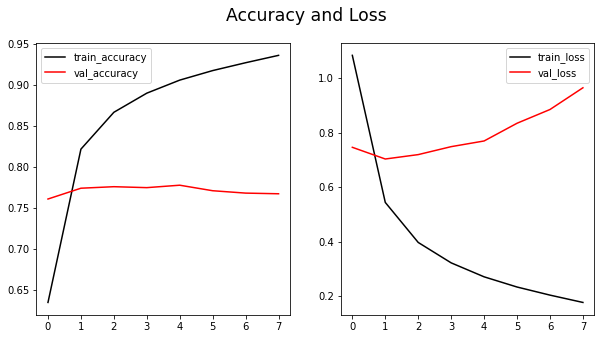

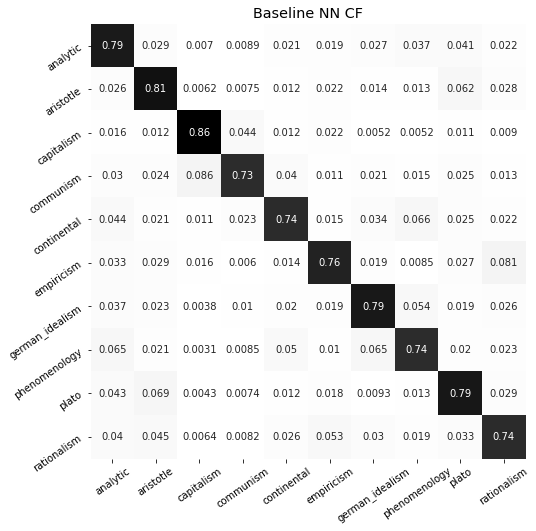




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     13407
           1       0.82      0.81      0.81     12156
           2       0.82      0.86      0.84      4580
           3       0.78      0.73      0.76      4523
           4       0.80      0.74      0.77      8526
           5       0.71      0.76      0.74      5033
           6       0.82      0.79      0.81     10511
           7       0.71      0.74      0.72      7145
           8       0.76      0.79      0.78      9536
           9       0.67      0.74      0.70      5618

    accuracy                           0.78     81035
   macro avg       0.77      0.78      0.77     81035
weighted avg       0.78      0.78      0.78     81035



In [37]:
summarize_model(history, test, preds, labels=flipped_dict, title='Baseline NN CF')

Seems good, though it did overfit towards the end. The flat accuracy curve seems to indicate that training did not actually help the model much at all, actually. 

Still, neural nets seem like they might be the way to go - let's try some options out!



### Hyperparameter Tuning

#### Try Using RMSprop instead of Adam

A different optimizer might help fix the lack of actual training improvement we saw in the last network. Here we try RMSprop.

In [38]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='rmsprop_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         21738496  
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                61400     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 21,800,406
Trainable params: 21,800,406
Non-trainable params: 0
_________________________________________________________________


None

In [39]:
RMSprop_history = model.fit(x_train_seq, y_train_seq, epochs=15,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/15
760/760 [==============================] - 84s 108ms/step - loss: 1.5369 - accuracy: 0.4654 - val_loss: 0.8413 - val_accuracy: 0.7307
Epoch 2/15
760/760 [==============================] - 81s 107ms/step - loss: 0.6886 - accuracy: 0.7759 - val_loss: 0.6961 - val_accuracy: 0.7741
Epoch 3/15
760/760 [==============================] - 82s 108ms/step - loss: 0.5619 - accuracy: 0.8153 - val_loss: 0.6776 - val_accuracy: 0.7808
Epoch 4/15
760/760 [==============================] - 82s 108ms/step - loss: 0.4970 - accuracy: 0.8351 - val_loss: 0.6698 - val_accuracy: 0.7827
Epoch 5/15
760/760 [==============================] - 82s 108ms/step - loss: 0.4567 - accuracy: 0.8483 - val_loss: 0.6530 - val_accuracy: 0.7901
Epoch 6/15
760/760 [==============================] - 81s 107ms/step - loss: 0.4244 - accuracy: 0.8581 - val_loss: 0.6478 - val_accuracy: 0.7925
Epoch 7/15
760/760 [==============================] - 82s 107ms/step - loss: 0.3930 - accuracy: 0.8696 - val_loss: 0.6861 - val_ac

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(RMSprop_history, test, preds, labels=flipped_dict, title='RMSprop CF')

This looks pretty good, in fact it's the best one yet at about 79% accuracy over 10 classes. We have some of the same issues with not learning as much, but it did seem to do a bit better than Adam. 

Next we'll try a basic SGD optimizer.

#### Trying Plain SGD Optimizer

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='rmsprop_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50,return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

In [21]:
SGD_history = model.fit(x_train_seq, y_train_seq, epochs=15,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/15
760/760 [==============================] - 79s 102ms/step - loss: 2.2985 - accuracy: 0.1032 - val_loss: 2.3003 - val_accuracy: 0.1278
Epoch 2/15
760/760 [==============================] - 75s 99ms/step - loss: 2.2980 - accuracy: 0.1336 - val_loss: 2.2969 - val_accuracy: 0.1470
Epoch 3/15
760/760 [==============================] - 76s 99ms/step - loss: 2.2979 - accuracy: 0.1442 - val_loss: 2.2886 - val_accuracy: 0.1470
Epoch 4/15
760/760 [==============================] - 76s 101ms/step - loss: 2.2856 - accuracy: 0.1473 - val_loss: 2.2688 - val_accuracy: 0.1468
Epoch 5/15
760/760 [==============================] - 77s 101ms/step - loss: 2.2739 - accuracy: 0.1437 - val_loss: 2.2586 - val_accuracy: 0.1488
Epoch 6/15
760/760 [==============================] - 76s 101ms/step - loss: 2.2660 - accuracy: 0.1514 - val_loss: 2.2542 - val_accuracy: 0.1584
Epoch 7/15
760/760 [==============================] - 76s 100ms/step - loss: 2.2572 - accuracy: 0.1604 - val_loss: 2.2333 - val_accu

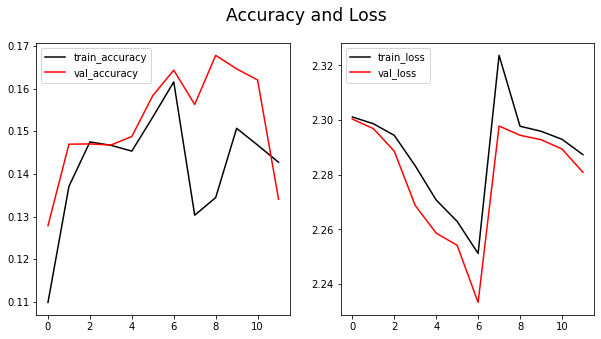

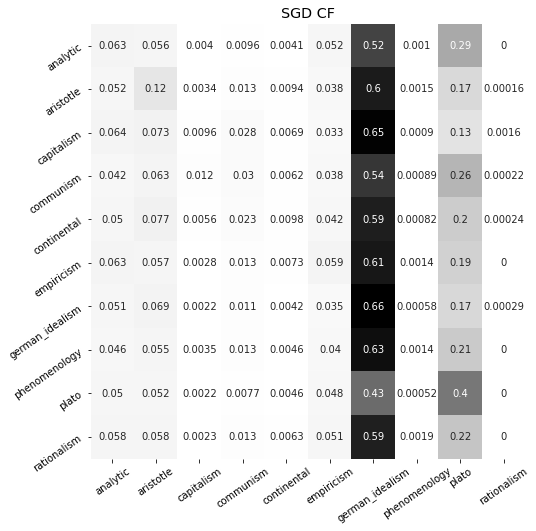




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.19      0.06      0.09     13576
           1       0.25      0.12      0.16     12145
           2       0.13      0.01      0.02      4466
           3       0.11      0.03      0.05      4486
           4       0.16      0.01      0.02      8507
           5       0.08      0.06      0.07      5068
           6       0.15      0.66      0.24     10372
           7       0.12      0.00      0.00      7129
           8       0.21      0.40      0.27      9577
           9       0.00      0.00      0.00      5709

    accuracy                           0.17     81035
   macro avg       0.14      0.14      0.09     81035
weighted avg       0.16      0.17      0.11     81035



In [22]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(SGD_history, test, preds, labels=flipped_dict, title='SGD CF')

These results are not inspiring at all. Let's stick to RMSprop and try out some different networks.

#### Try Using GRU instead of LSTM

In [40]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, 
                                                                                     tokenizer_name='gru_tokenizer.pkl')

# Trying out GRU
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(GRU(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         10852736  
_________________________________________________________________
gru (GRU)                    (None, 50)                27000     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 10,880,246
Trainable params: 10,880,246
Non-trainable params: 0
_________________________________________________________________


None

In [41]:
GRU_history = model.fit(x_train_seq, y_train_seq, epochs=15,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/15
760/760 [==============================] - 50s 64ms/step - loss: 1.7831 - accuracy: 0.3547 - val_loss: 0.9361 - val_accuracy: 0.6933
Epoch 2/15
760/760 [==============================] - 49s 64ms/step - loss: 0.8169 - accuracy: 0.7329 - val_loss: 0.7860 - val_accuracy: 0.7452
Epoch 3/15
760/760 [==============================] - 49s 64ms/step - loss: 0.6457 - accuracy: 0.7875 - val_loss: 0.6935 - val_accuracy: 0.7733
Epoch 4/15
760/760 [==============================] - 49s 64ms/step - loss: 0.5524 - accuracy: 0.8190 - val_loss: 0.6704 - val_accuracy: 0.7842
Epoch 5/15
760/760 [==============================] - 49s 64ms/step - loss: 0.4895 - accuracy: 0.8387 - val_loss: 0.6613 - val_accuracy: 0.7869
Epoch 6/15
760/760 [==============================] - 49s 64ms/step - loss: 0.4544 - accuracy: 0.8510 - val_loss: 0.6515 - val_accuracy: 0.7900
Epoch 7/15
760/760 [==============================] - 49s 64ms/step - loss: 0.4169 - accuracy: 0.8613 - val_loss: 0.6767 - val_accuracy:

GRU seems to be not appreciably different than LSTM on this task.



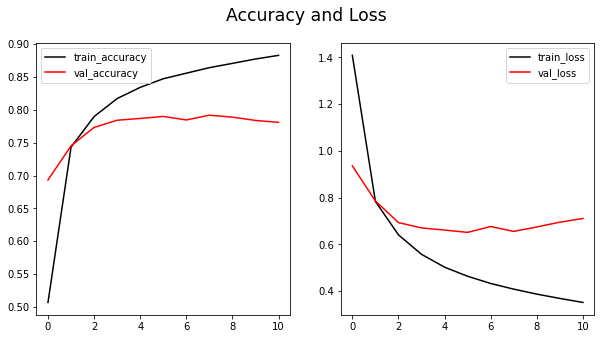

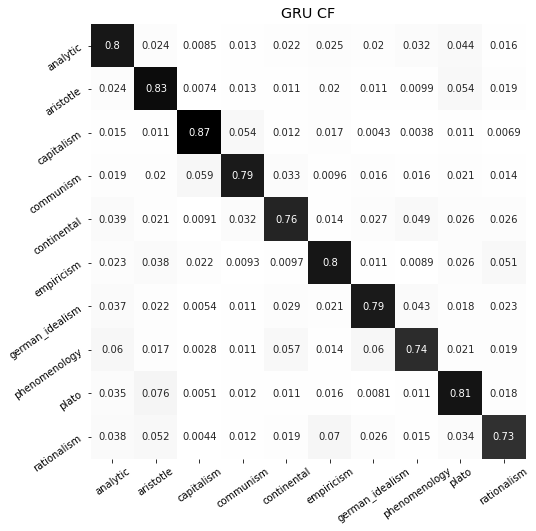




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.80      0.81     13576
           1       0.82      0.83      0.83     12145
           2       0.83      0.87      0.85      4466
           3       0.74      0.79      0.76      4486
           4       0.80      0.76      0.78      8507
           5       0.71      0.80      0.75      5068
           6       0.85      0.79      0.82     10372
           7       0.75      0.74      0.75      7129
           8       0.77      0.81      0.79      9577
           9       0.73      0.73      0.73      5709

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.79     81035
weighted avg       0.79      0.79      0.79     81035



In [42]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(GRU_history, test, preds, labels=flipped_dict, title='GRU CF')

79% accuracy, as before, and with the same tendency to stop learning quite quickly. Still, it does learn better than adam version we have run in the past. 

#### Bidirectional LSTM

In [43]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, 
                                                                                     tokenizer_name='bidirectional_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model


model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         10876288  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               71600     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 10,948,898
Trainable params: 10,948,898
Non-trainable params: 0
_________________________________________________________________


None

In [44]:
bidirectional_history = model.fit(x_train_seq, y_train_seq, epochs=15,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/15
760/760 [==============================] - 73s 92ms/step - loss: 1.6718 - accuracy: 0.3993 - val_loss: 0.9290 - val_accuracy: 0.7005
Epoch 2/15
760/760 [==============================] - 69s 91ms/step - loss: 0.8062 - accuracy: 0.7388 - val_loss: 0.7473 - val_accuracy: 0.7591
Epoch 3/15
760/760 [==============================] - 69s 91ms/step - loss: 0.6238 - accuracy: 0.7965 - val_loss: 0.6917 - val_accuracy: 0.7761
Epoch 4/15
760/760 [==============================] - 69s 91ms/step - loss: 0.5427 - accuracy: 0.8207 - val_loss: 0.6732 - val_accuracy: 0.7843
Epoch 5/15
760/760 [==============================] - 69s 90ms/step - loss: 0.4974 - accuracy: 0.8339 - val_loss: 0.6599 - val_accuracy: 0.7881
Epoch 6/15
760/760 [==============================] - 69s 91ms/step - loss: 0.4620 - accuracy: 0.8459 - val_loss: 0.6858 - val_accuracy: 0.7807
Epoch 7/15
760/760 [==============================] - 69s 91ms/step - loss: 0.4378 - accuracy: 0.8531 - val_loss: 0.6643 - val_accuracy:

Looks good, more or less on par with the baseline unidirectional LSTM. 

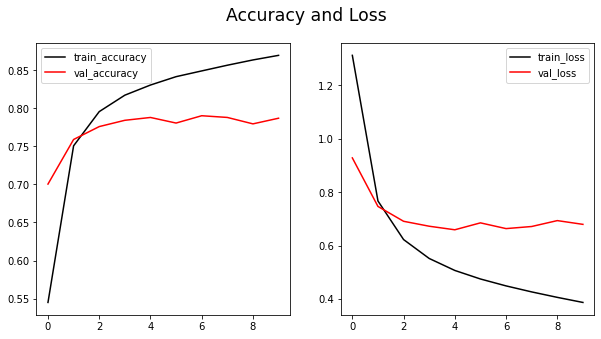

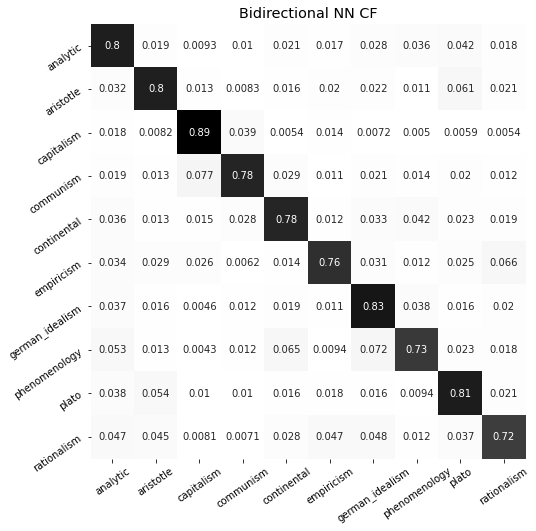




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     13549
           1       0.86      0.80      0.83     12274
           2       0.79      0.89      0.84      4608
           3       0.77      0.78      0.78      4416
           4       0.80      0.78      0.79      8438
           5       0.74      0.76      0.75      4996
           6       0.80      0.83      0.81     10368
           7       0.75      0.73      0.74      7024
           8       0.77      0.81      0.79      9579
           9       0.72      0.72      0.72      5783

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [45]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Bidirectional NN CF')

This printout could be the one we saw before. Still some overtraining - we probably don't need all those epochs. 

#### Multiple LSTM Layers 

Next, let's try training a model with multiple LSTM layers to see if that improves performance.

In [46]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, 
                                                                                     tokenizer_name='multi_lstm_tokenizer.pkl')

# commented out layers indicate past attempts
# none were particularly successful
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         10823936  
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
Total params: 10,880,446
Trainable params: 10,880,446
Non-trainable params: 0
_________________________________________________________________


None

In [47]:
multi_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 70s 87ms/step - loss: 1.6149 - accuracy: 0.4373 - val_loss: 0.8988 - val_accuracy: 0.7073
Epoch 2/10
760/760 [==============================] - 66s 87ms/step - loss: 0.7808 - accuracy: 0.7420 - val_loss: 0.7154 - val_accuracy: 0.7667
Epoch 3/10
760/760 [==============================] - 66s 87ms/step - loss: 0.6095 - accuracy: 0.7997 - val_loss: 0.6878 - val_accuracy: 0.7778
Epoch 4/10
760/760 [==============================] - 66s 86ms/step - loss: 0.5363 - accuracy: 0.8225 - val_loss: 0.6770 - val_accuracy: 0.7805
Epoch 5/10
760/760 [==============================] - 66s 87ms/step - loss: 0.4884 - accuracy: 0.8372 - val_loss: 0.7084 - val_accuracy: 0.7715
Epoch 6/10
760/760 [==============================] - 66s 87ms/step - loss: 0.4541 - accuracy: 0.8493 - val_loss: 0.6834 - val_accuracy: 0.7820
Epoch 7/10
760/760 [==============================] - 66s 87ms/step - loss: 0.4220 - accuracy: 0.8587 - val_loss: 0.6502 - val_accuracy:

Similar result again, though our best model so far with almost 80% accuracy. 

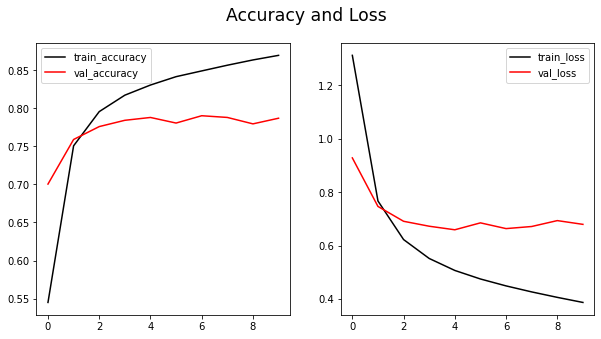

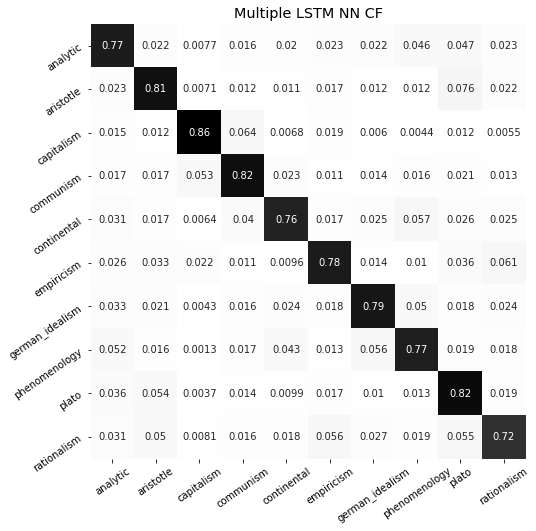




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.77      0.80     13480
           1       0.84      0.81      0.82     12127
           2       0.84      0.86      0.85      4537
           3       0.70      0.82      0.75      4475
           4       0.83      0.76      0.79      8501
           5       0.71      0.78      0.74      4975
           6       0.85      0.79      0.82     10609
           7       0.72      0.77      0.74      7110
           8       0.74      0.82      0.78      9539
           9       0.70      0.72      0.71      5682

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [48]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(bidirectional_history, test, preds, labels=flipped_dict, title='Multiple LSTM NN CF')

More or less the same as past models. More layers don't seem to hurt (except when it comes to training time), but they don't seem to help much either. 

#### More LSTM Neurons

In [49]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y,
                                                                                     tokenizer_name='extra_lstm_nn_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(100, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         10842624  
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 10,935,234
Trainable params: 10,935,234
Non-trainable params: 0
_________________________________________________________________


None

In [50]:
extra_LSTM_neurons_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=set_early_stop(),
                                  class_weight=weights_dict)

Epoch 1/10
760/760 [==============================] - 59s 76ms/step - loss: 1.6057 - accuracy: 0.4359 - val_loss: 0.8242 - val_accuracy: 0.7328
Epoch 2/10
760/760 [==============================] - 57s 75ms/step - loss: 0.7030 - accuracy: 0.7704 - val_loss: 0.7316 - val_accuracy: 0.7612
Epoch 3/10
760/760 [==============================] - 57s 75ms/step - loss: 0.5733 - accuracy: 0.8118 - val_loss: 0.6997 - val_accuracy: 0.7749
Epoch 4/10
760/760 [==============================] - 57s 75ms/step - loss: 0.5173 - accuracy: 0.8291 - val_loss: 0.6918 - val_accuracy: 0.7771
Epoch 5/10
760/760 [==============================] - 57s 75ms/step - loss: 0.4792 - accuracy: 0.8404 - val_loss: 0.6585 - val_accuracy: 0.7884
Epoch 6/10
760/760 [==============================] - 57s 75ms/step - loss: 0.4433 - accuracy: 0.8528 - val_loss: 0.6673 - val_accuracy: 0.7856
Epoch 7/10
760/760 [==============================] - 57s 76ms/step - loss: 0.4215 - accuracy: 0.8587 - val_loss: 0.6658 - val_accuracy:

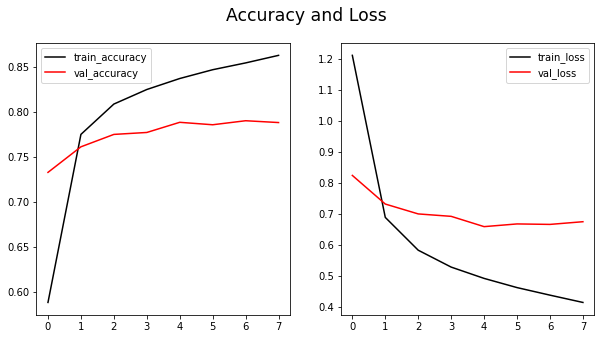

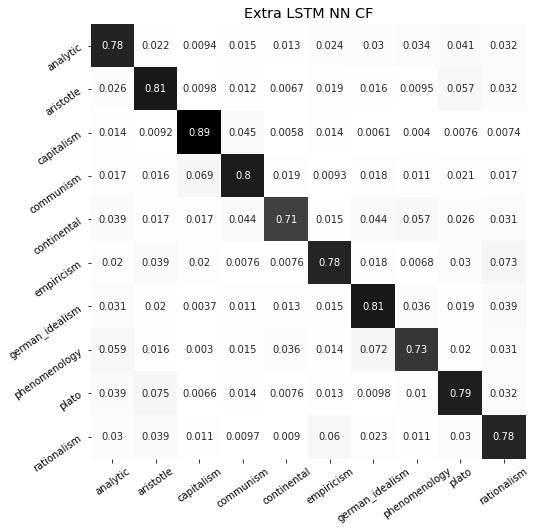




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.78      0.80     13461
           1       0.83      0.81      0.82     12359
           2       0.80      0.89      0.84      4452
           3       0.73      0.80      0.76      4505
           4       0.87      0.71      0.78      8356
           5       0.72      0.78      0.75      5015
           6       0.82      0.81      0.81     10495
           7       0.75      0.73      0.74      7049
           8       0.77      0.79      0.78      9590
           9       0.64      0.78      0.70      5753

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [51]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_LSTM_neurons_history, test, preds, labels=flipped_dict, title='Extra LSTM NN CF')

This actually seems to have gotten mildly worse. Let's see if adding a dense layer changes anything.

#### Adding Dense Layers

In [52]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='extra_dense_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         10861056  
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

None

In [53]:
extra_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 76s 98ms/step - loss: 1.9791 - accuracy: 0.2572 - val_loss: 1.1657 - val_accuracy: 0.6052
Epoch 2/20
760/760 [==============================] - 74s 97ms/step - loss: 1.2922 - accuracy: 0.5256 - val_loss: 1.0354 - val_accuracy: 0.6345
Epoch 3/20
760/760 [==============================] - 73s 96ms/step - loss: 1.1233 - accuracy: 0.5853 - val_loss: 0.9919 - val_accuracy: 0.6583
Epoch 4/20
760/760 [==============================] - 73s 97ms/step - loss: 1.0341 - accuracy: 0.6216 - val_loss: 1.0555 - val_accuracy: 0.6466
Epoch 5/20
760/760 [==============================] - 73s 97ms/step - loss: 0.9792 - accuracy: 0.6405 - val_loss: 0.9809 - val_accuracy: 0.6784
Epoch 6/20
760/760 [==============================] - 73s 96ms/step - loss: 0.8988 - accuracy: 0.6664 - val_loss: 1.0196 - val_accuracy: 0.6926
Epoch 7/20
760/760 [==============================] - 74s 97ms/step - loss: 0.8514 - accuracy: 0.6921 - val_loss: 1.0699 - val_accuracy:

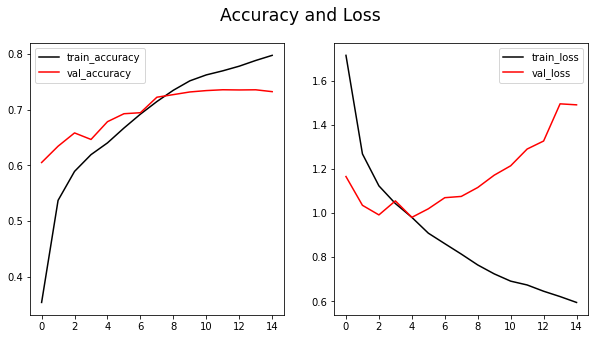

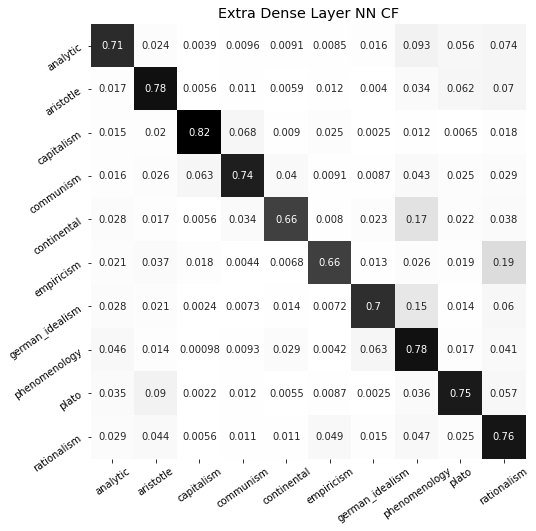




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     13225
           1       0.80      0.78      0.79     12154
           2       0.85      0.82      0.84      4445
           3       0.74      0.74      0.74      4616
           4       0.86      0.66      0.75      8576
           5       0.78      0.66      0.72      4981
           6       0.87      0.70      0.78     10518
           7       0.50      0.78      0.61      7173
           8       0.76      0.75      0.75      9601
           9       0.48      0.76      0.59      5746

    accuracy                           0.73     81035
   macro avg       0.75      0.74      0.73     81035
weighted avg       0.76      0.73      0.74     81035



In [54]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(extra_dense_history, test, preds, labels=flipped_dict, title='Extra Dense Layer NN CF')

This one actually seemed to do worse than most of the other models. A dense layer doesn't seem to improve performance. 

#### Batch Size Changes

##### Batch - 512

First, the baseline model but with double the batch size.

In [55]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='big_batch_size.pkl.')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         10842496  
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
Total params: 10,878,806
Trainable params: 10,878,806
Non-trainable params: 0
_________________________________________________________________


None

In [56]:
more_batches_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 39s 99ms/step - loss: 1.7765 - accuracy: 0.3675 - val_loss: 0.9855 - val_accuracy: 0.6830
Epoch 2/10
380/380 [==============================] - 37s 98ms/step - loss: 0.8324 - accuracy: 0.7307 - val_loss: 0.7805 - val_accuracy: 0.7469
Epoch 3/10
380/380 [==============================] - 37s 98ms/step - loss: 0.6250 - accuracy: 0.7948 - val_loss: 0.7202 - val_accuracy: 0.7684
Epoch 4/10
380/380 [==============================] - 37s 99ms/step - loss: 0.5287 - accuracy: 0.8249 - val_loss: 0.7299 - val_accuracy: 0.7659
Epoch 5/10
380/380 [==============================] - 37s 98ms/step - loss: 0.4769 - accuracy: 0.8410 - val_loss: 0.6711 - val_accuracy: 0.7862
Epoch 6/10
380/380 [==============================] - 38s 99ms/step - loss: 0.4449 - accuracy: 0.8515 - val_loss: 0.6948 - val_accuracy: 0.7777
Epoch 7/10
380/380 [==============================] - 38s 99ms/step - loss: 0.4162 - accuracy: 0.8596 - val_loss: 0.6837 - val_accuracy:

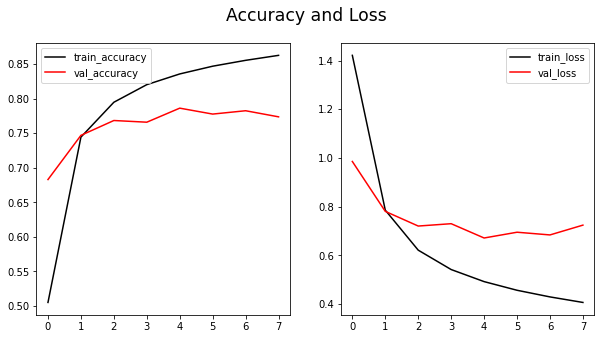

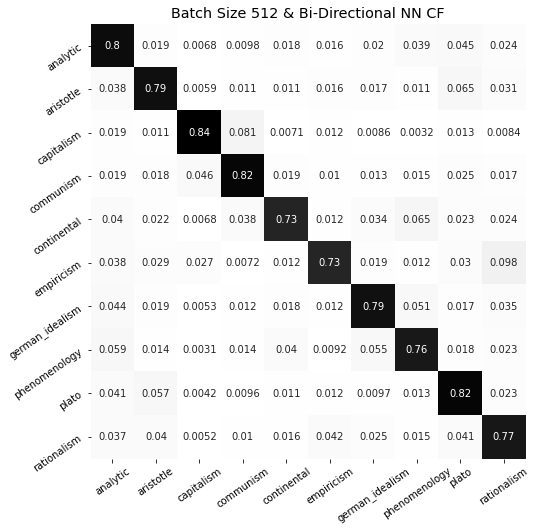




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     13427
           1       0.84      0.79      0.82     12067
           2       0.84      0.84      0.84      4648
           3       0.73      0.82      0.77      4599
           4       0.84      0.73      0.78      8383
           5       0.76      0.73      0.74      4994
           6       0.84      0.79      0.81     10585
           7       0.72      0.76      0.74      7041
           8       0.76      0.82      0.79      9567
           9       0.66      0.77      0.71      5724

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [57]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(more_batches_LSTM_history, test, preds, labels=flipped_dict, title='Batch Size 512 & NN CF')

Not any real improvement here.

Next let's try the same but with smaller batch sizes.

##### Batch - 128

In [58]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='128-batch.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 128)         10854144  
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
Total params: 10,890,454
Trainable params: 10,890,454
Non-trainable params: 0
_________________________________________________________________


None

In [59]:
batches_size_128 = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=128, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
1520/1520 [==============================] - 84s 54ms/step - loss: 1.5444 - accuracy: 0.4459 - val_loss: 0.8405 - val_accuracy: 0.7281
Epoch 2/10
1520/1520 [==============================] - 82s 54ms/step - loss: 0.7096 - accuracy: 0.7675 - val_loss: 0.7228 - val_accuracy: 0.7659
Epoch 3/10
1520/1520 [==============================] - 81s 54ms/step - loss: 0.5891 - accuracy: 0.8061 - val_loss: 0.6771 - val_accuracy: 0.7801
Epoch 4/10
1520/1520 [==============================] - 81s 53ms/step - loss: 0.5336 - accuracy: 0.8236 - val_loss: 0.7388 - val_accuracy: 0.7616
Epoch 5/10
1520/1520 [==============================] - 81s 53ms/step - loss: 0.4979 - accuracy: 0.8346 - val_loss: 0.6698 - val_accuracy: 0.7838
Epoch 6/10
1520/1520 [==============================] - 81s 54ms/step - loss: 0.4657 - accuracy: 0.8463 - val_loss: 0.6501 - val_accuracy: 0.7909
Epoch 7/10
1520/1520 [==============================] - 82s 54ms/step - loss: 0.4351 - accuracy: 0.8568 - val_loss: 0.6416 -

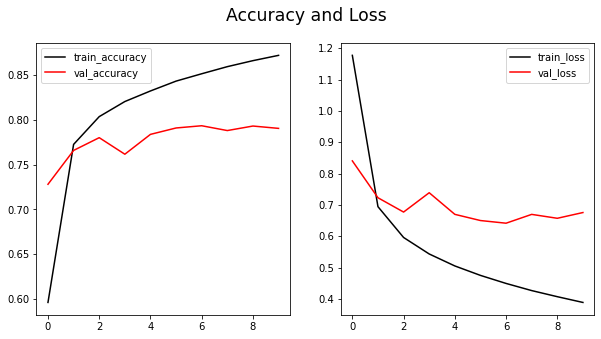

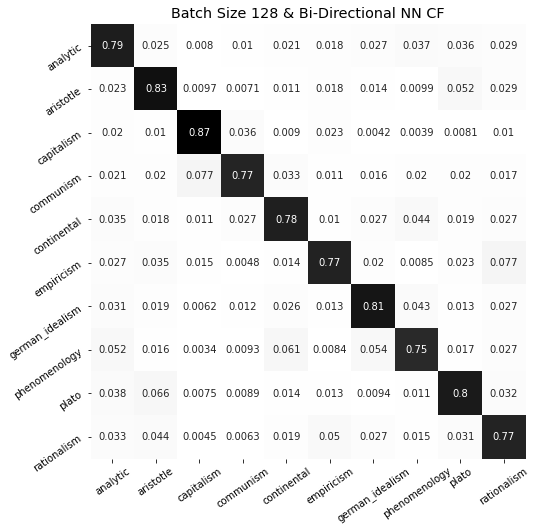




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     13420
           1       0.83      0.83      0.83     12259
           2       0.81      0.87      0.84      4578
           3       0.78      0.77      0.77      4361
           4       0.80      0.78      0.79      8366
           5       0.75      0.77      0.76      5038
           6       0.84      0.81      0.83     10585
           7       0.75      0.75      0.75      7132
           8       0.80      0.80      0.80      9547
           9       0.66      0.77      0.71      5749

    accuracy                           0.80     81035
   macro avg       0.79      0.79      0.79     81035
weighted avg       0.80      0.80      0.80     81035



In [60]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(batches_size_128, test, preds, labels=flipped_dict, title='Batch Size 128 NN CF')

These results seem fine, but not really special.


##### Batch - 64

In [61]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='64-batch.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         10858752  
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                510       
Total params: 10,895,062
Trainable params: 10,895,062
Non-trainable params: 0
_________________________________________________________________


None

In [62]:
batches_size_64 = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=64, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
3039/3039 [==============================] - 136s 44ms/step - loss: 1.4563 - accuracy: 0.4872 - val_loss: 0.7880 - val_accuracy: 0.7456
Epoch 2/10
3039/3039 [==============================] - 135s 44ms/step - loss: 0.7118 - accuracy: 0.7680 - val_loss: 0.7371 - val_accuracy: 0.7608
Epoch 3/10
3039/3039 [==============================] - 135s 44ms/step - loss: 0.6047 - accuracy: 0.8033 - val_loss: 0.6707 - val_accuracy: 0.7814
Epoch 4/10
3039/3039 [==============================] - 148s 49ms/step - loss: 0.5412 - accuracy: 0.8224 - val_loss: 0.6661 - val_accuracy: 0.7851
Epoch 5/10
3039/3039 [==============================] - 147s 48ms/step - loss: 0.4981 - accuracy: 0.8371 - val_loss: 0.6611 - val_accuracy: 0.7876
Epoch 6/10
3039/3039 [==============================] - 147s 48ms/step - loss: 0.4702 - accuracy: 0.8457 - val_loss: 0.6435 - val_accuracy: 0.7942
Epoch 7/10
3039/3039 [==============================] - 148s 49ms/step - loss: 0.4473 - accuracy: 0.8522 - val_loss: 0

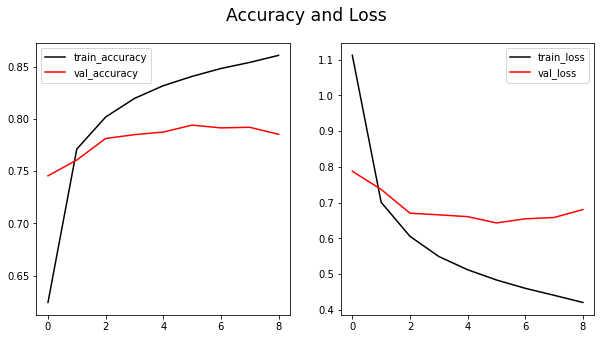

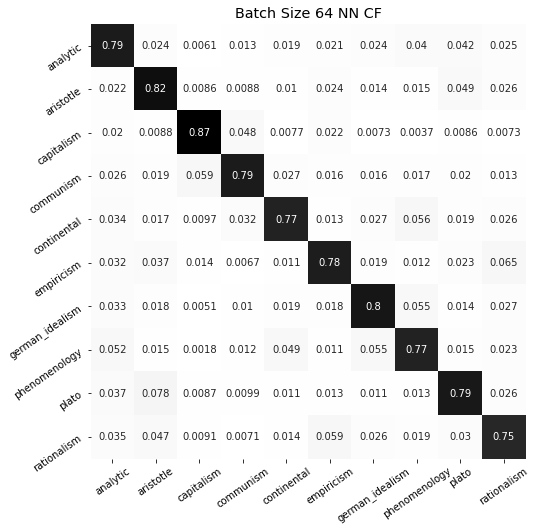




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     13321
           1       0.83      0.82      0.83     12121
           2       0.83      0.87      0.85      4540
           3       0.75      0.79      0.77      4463
           4       0.83      0.77      0.80      8645
           5       0.71      0.78      0.74      4944
           6       0.84      0.80      0.82     10585
           7       0.72      0.77      0.74      7151
           8       0.79      0.79      0.79      9522
           9       0.69      0.75      0.72      5743

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.79     81035
weighted avg       0.80      0.79      0.79     81035



In [63]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(batches_size_64, test, preds, labels=flipped_dict, title='Batch Size 64 NN CF')

Another fine, but not particularly new or exciting, result.

##### Batch - 32

In [64]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450,
                                                                                     tokenizer_name='32-batch.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 128)         10878464  
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
Total params: 10,914,774
Trainable params: 10,914,774
Non-trainable params: 0
_________________________________________________________________


None

In [65]:
batches_size_32 = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=32, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
6078/6078 [==============================] - 249s 41ms/step - loss: 1.3958 - accuracy: 0.5159 - val_loss: 0.8088 - val_accuracy: 0.7388
Epoch 2/10
6078/6078 [==============================] - 241s 40ms/step - loss: 0.7144 - accuracy: 0.7672 - val_loss: 0.7318 - val_accuracy: 0.7635
Epoch 3/10
6078/6078 [==============================] - 242s 40ms/step - loss: 0.6029 - accuracy: 0.8027 - val_loss: 0.6722 - val_accuracy: 0.7834
Epoch 4/10
6078/6078 [==============================] - 242s 40ms/step - loss: 0.5424 - accuracy: 0.8236 - val_loss: 0.6629 - val_accuracy: 0.7840
Epoch 5/10
6078/6078 [==============================] - 243s 40ms/step - loss: 0.5062 - accuracy: 0.8357 - val_loss: 0.6669 - val_accuracy: 0.7851
Epoch 6/10
6078/6078 [==============================] - 243s 40ms/step - loss: 0.4783 - accuracy: 0.8431 - val_loss: 0.6768 - val_accuracy: 0.7842
Epoch 7/10
6078/6078 [==============================] - 243s 40ms/step - loss: 0.4613 - accuracy: 0.8488 - val_loss: 0

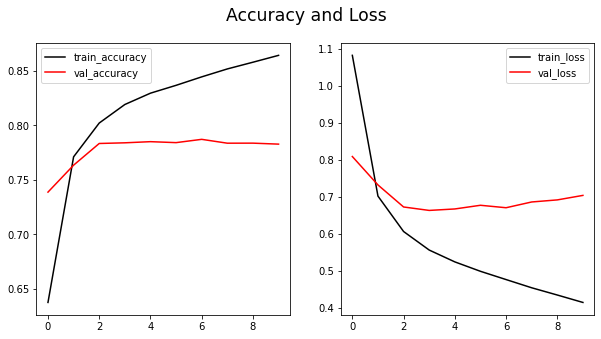

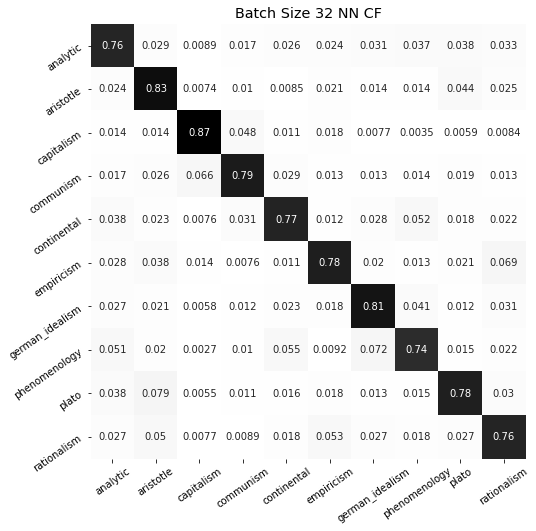




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     13324
           1       0.81      0.83      0.82     12100
           2       0.83      0.87      0.85      4547
           3       0.74      0.79      0.77      4521
           4       0.81      0.77      0.79      8450
           5       0.72      0.78      0.75      5007
           6       0.82      0.81      0.82     10508
           7       0.73      0.74      0.74      7139
           8       0.81      0.78      0.79      9704
           9       0.67      0.76      0.71      5735

    accuracy                           0.79     81035
   macro avg       0.78      0.79      0.78     81035
weighted avg       0.79      0.79      0.79     81035



In [66]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(batches_size_32, test, preds, labels=flipped_dict, title='Batch Size 32 NN CF')

#### A Bit of Everything!

In [67]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# two dense layers, an LSTM layer, and a bi-directional layer!
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(50, return_sequences=True))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(50,return_sequences=False)))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 128)         10848128  
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 50)          35800     
_________________________________________________________________
dense_16 (Dense)             (None, None, 25)          1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 25)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               30400     
_________________________________________________________________
dense_17 (Dense)             (None, 25)                2525      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)              

None

In [68]:
LSTM_bi_dense_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=512, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/10
380/380 [==============================] - 75s 186ms/step - loss: 2.0499 - accuracy: 0.2307 - val_loss: 1.1729 - val_accuracy: 0.5895
Epoch 2/10
380/380 [==============================] - 69s 182ms/step - loss: 1.2197 - accuracy: 0.5852 - val_loss: 0.9427 - val_accuracy: 0.6886
Epoch 3/10
380/380 [==============================] - 70s 184ms/step - loss: 0.9670 - accuracy: 0.6821 - val_loss: 0.8822 - val_accuracy: 0.7190
Epoch 4/10
380/380 [==============================] - 70s 183ms/step - loss: 0.8484 - accuracy: 0.7284 - val_loss: 0.8623 - val_accuracy: 0.7377
Epoch 5/10
380/380 [==============================] - 69s 182ms/step - loss: 0.7592 - accuracy: 0.7593 - val_loss: 0.8513 - val_accuracy: 0.7437
Epoch 6/10
380/380 [==============================] - 70s 183ms/step - loss: 0.6920 - accuracy: 0.7807 - val_loss: 0.8546 - val_accuracy: 0.7508
Epoch 7/10
380/380 [==============================] - 70s 184ms/step - loss: 0.6431 - accuracy: 0.7968 - val_loss: 0.8616 - val_ac

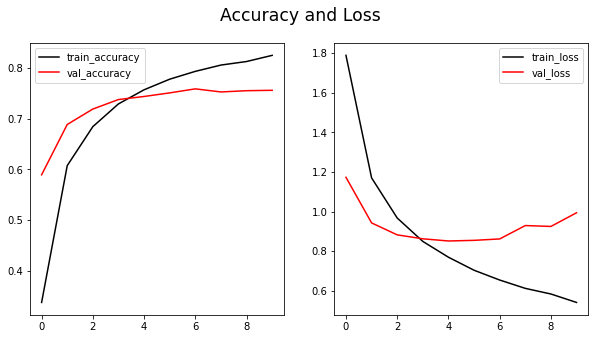

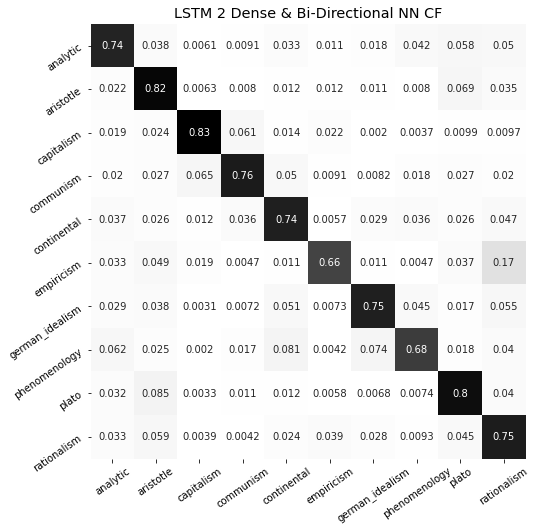




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     13394
           1       0.77      0.82      0.79     12310
           2       0.84      0.83      0.84      4544
           3       0.75      0.76      0.75      4521
           4       0.73      0.74      0.74      8431
           5       0.79      0.66      0.72      4876
           6       0.84      0.75      0.79     10552
           7       0.74      0.68      0.71      7123
           8       0.73      0.80      0.76      9573
           9       0.54      0.75      0.63      5711

    accuracy                           0.76     81035
   macro avg       0.76      0.75      0.75     81035
weighted avg       0.76      0.76      0.76     81035



In [69]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(LSTM_bi_dense_history, test, preds, labels=flipped_dict, title='LSTM 2 Dense & Bi-Directional NN CF')

These results were again in the range of the rest. At this point it's clear that we can achieve about 75% accuracy with most types of models; we're looking for something that can jump us up to 80% or more.

Let's try extra dense layers, this time with three of them. 

In [8]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450)

# three dense layers on top of an LSTM layer
def make_model(embedding_size = 128):
    model=Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, embedding_size))
    model.add(LSTM(75, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         10869248  
_________________________________________________________________
lstm (LSTM)                  (None, 75)                61200     
_________________________________________________________________
dense (Dense)                (None, 25)                1900      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                6

None

In [14]:
# extra epochs since the last extra dense layer model seemed to improve for longer
triple_dense_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Epoch 1/20
760/760 [==============================] - 83s 106ms/step - loss: 2.0293 - accuracy: 0.2096 - val_loss: 1.5266 - val_accuracy: 0.3974
Epoch 2/20
760/760 [==============================] - 78s 102ms/step - loss: 1.4448 - accuracy: 0.4376 - val_loss: 1.2628 - val_accuracy: 0.5813
Epoch 3/20
760/760 [==============================] - 80s 106ms/step - loss: 1.2013 - accuracy: 0.5775 - val_loss: 1.1330 - val_accuracy: 0.6442
Epoch 4/20
760/760 [==============================] - 77s 102ms/step - loss: 1.0584 - accuracy: 0.6445 - val_loss: 1.0856 - val_accuracy: 0.6620
Epoch 5/20
760/760 [==============================] - 80s 105ms/step - loss: 0.9715 - accuracy: 0.6756 - val_loss: 1.0742 - val_accuracy: 0.6824
Epoch 6/20
760/760 [==============================] - 77s 101ms/step - loss: 0.8955 - accuracy: 0.7031 - val_loss: 1.0898 - val_accuracy: 0.6912
Epoch 7/20
760/760 [==============================] - 79s 104ms/step - loss: 0.8432 - accuracy: 0.7236 - val_loss: 1.1082 - val_ac

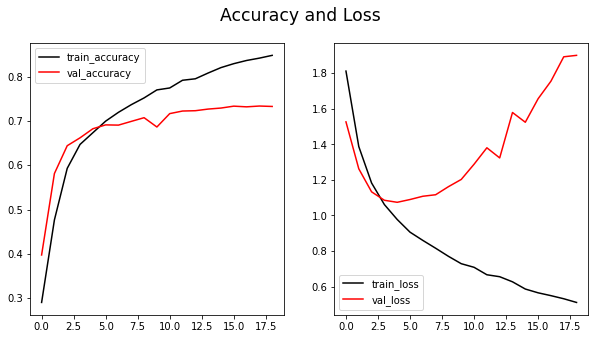

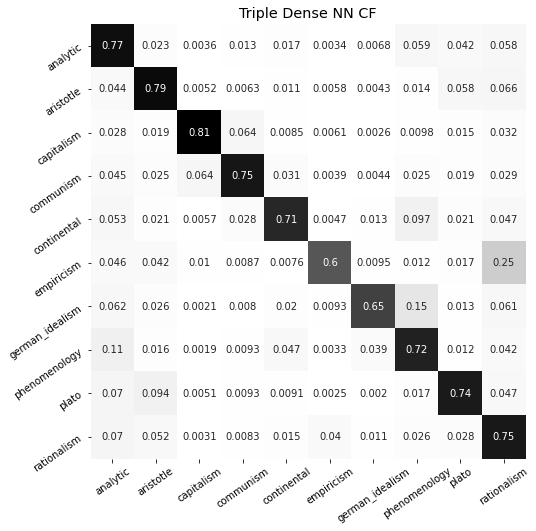




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.77      0.74     13197
           1       0.80      0.79      0.79     12252
           2       0.86      0.81      0.84      4613
           3       0.76      0.75      0.75      4562
           4       0.82      0.71      0.76      8423
           5       0.84      0.60      0.70      4969
           6       0.91      0.65      0.76     10371
           7       0.57      0.72      0.64      7203
           8       0.78      0.74      0.76      9674
           9       0.47      0.75      0.58      5771

    accuracy                           0.73     81035
   macro avg       0.75      0.73      0.73     81035
weighted avg       0.76      0.73      0.74     81035



In [15]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(triple_dense_history, test, preds, labels=flipped_dict, title='Triple Dense NN CF')

Not particularly inspiring, in fact this is worse than just two dense layers. 

We've tried a decent number of options here. Next let's see what happens if we bring in word embeddings from GloVe.

### Using Glove Word Embeddings

In [ ]:
glove_file = datapath('/gdrive/MyDrive/Colab_Projects/Phil_NLP/glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_vectors = KeyedVectors.load_word2vec_format(tmp_file)

In [ ]:
tokenizer, x_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='glove_tokenizer.pkl')

def make_model(embedding_size = 128):
    model=Sequential()

    model.add(glove_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

In [ ]:
glove_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=20,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

Not very promising - perhaps the vectors that worked from 
GloVe and were trained on our data would be better?

### Custom Word Embeddings

Initial efforts to build models with our custom embeddings did have promising results. We did want to work more on tuning hyperparameters, but encountered problems with our w2v model size. In the end, we didn't have time to explore this avenue further. 

In [ ]:
custom_vectors = KeyedVectors.load('/gdrive/MyDrive/Colab_Projects/Phil_NLP/w2v_models/w2v_for_nn.wordvectors')

In [ ]:
custom_vectors.most_similar('philosophy')

[('metaphysics', 0.7894171476364136),
 ('theology', 0.7694715261459351),
 ('religion', 0.7320282459259033),
 ('science', 0.728236734867096),
 ('philosophical', 0.7186429500579834),
 ('transcendental philosophy', 0.7153382301330566),
 ('natural science', 0.7118123769760132),
 ('psychology', 0.7090511322021484),
 ('politics', 0.6923774480819702),
 ('skepticism', 0.6838987469673157)]

In [ ]:
tokenizer, x_train_seqx_train_seq, x_test_seq, y_train_seq, y_test_seq, weights_dict = nn_setup(x,y, max_length=450, tokenizer_name='custom_w2v_tokenizer.pkl')

def make_model(embedding_size = 256):
    model=Sequential()

    model.add(custom_vectors.get_keras_embedding())
    model.add(LSTM(50, return_sequences=False))

    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    display(model.summary())
    return model

model = make_model()

In [ ]:
len(tokenizer.word_index)

In [ ]:
len(custom_vectors.vocab)

In [ ]:
custom_embeddings_LSTM_history = model.fit(x_train_seq, y_train_seq, epochs=10,
                                  batch_size=256, validation_split=0.2,
                                  callbacks=list_callbacks(),
                                  class_weight=weights_dict)

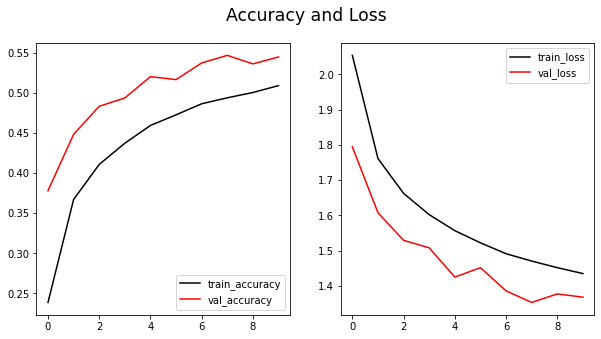

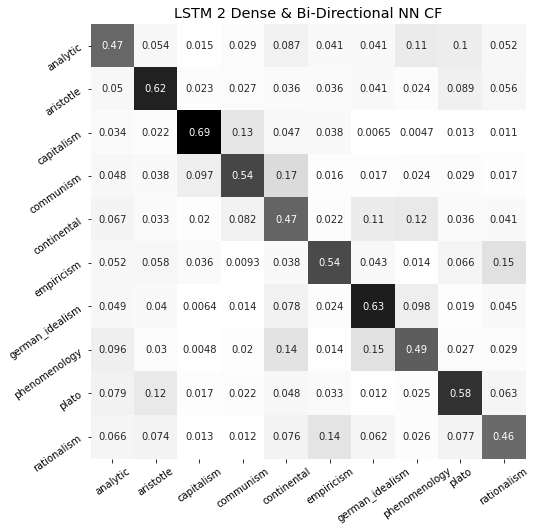




			CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.60      0.47      0.52     13403
           1       0.68      0.62      0.65     12702
           2       0.66      0.69      0.68      4640
           3       0.49      0.54      0.51      4601
           4       0.42      0.47      0.44      8329
           5       0.48      0.54      0.51      5062
           6       0.63      0.63      0.63     10554
           7       0.44      0.49      0.47      7140
           8       0.57      0.58      0.58      9659
           9       0.40      0.46      0.43      5722

    accuracy                           0.55     81812
   macro avg       0.54      0.55      0.54     81812
weighted avg       0.56      0.55      0.55     81812



In [ ]:
preds = model.predict(x_test_seq).argmax(axis=1)
test = np.argmax(y_test_seq, axis=1)

summarize_model(custom_embeddings_LSTM_history, test, preds, labels=flipped_dict, title='Custom Embeddings LSTM NN CF')

Above you can see the initial result of the model working with our w2v custom embeddings. 

### Conclusion

Overall, deep NLP yielded the best models that we had in our project, with nearly 80% accuracy. 

RMSprop turned out to be a better optimizer than Adam for this dataset. 

Word embeddings did not yield promising results at first, but are something to explore further. We'd also like to try different optimizers.

Unfortunately, none of our models showed much impressive actual learning. Instead, they hit a certain accuracy within a couple epochs and would typically stay there with minor deviations as epochs went by; this is reflected in nearly all our training curves. We're not sure why we got this result and our future efforts would be directed to trying to fix this issue.

Nonetheless, 80% accuracy over 10 classes is a result we can be happy with. 

#### Recommendations & Future Work

Overall, we were able to attain about 80% accuracy over 10 classes - a solid result. Our w2v models gave clear pictures of their respective schools, though they were less helpful at the level of authors since they had less text to go on there. The data was visualized and made available for use in classification and exploration on a dash app. The repo for that app is [here](https://github.com/kcalizadeh/phil_nlp_dashboard).

The solid accuracy scores and wide-open potential applications of the model made the project seem like a promising one for further development. Our next steps include:

- working with the Twitter API to build a function that can take a Twitter user's handle and generate a classification for that user.
- adding additional texts to the corpus, especially those associated with Stoicism, eastern philosophy (Confucianism, Taoism, Buddhism), and contemporary political movements.
- building a recommender system to recommend books or other media based on a user's philosophical leanings.

Thank you for your interest. If you are interested in contributing to the project or have questions about it, please feel free to email me at kcalizadeh@gmail.com or to reach out on Twitter - @aslidsiksoraksi.